In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [69]:
import tensorflow as tf
import tensorflow_datasets as tfds
from layers.kWTA import KWTA
import matplotlib.pyplot as plt
import numpy as np
import itertools
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

[autoreload of traitlets.traitlets failed: Traceback (most recent call last):
  File "/Users/moritzeich/.pyenv/versions/3.10.6/envs/tensorflow/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/moritzeich/.pyenv/versions/3.10.6/envs/tensorflow/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/moritzeich/.pyenv/versions/3.10.6/envs/tensorflow/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/moritzeich/.pyenv/versions/3.10.6/envs/tensorflow/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/Users/moritzeich/.pyenv/versions/3.10.6/envs/tensorflow/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    object.__setatt

[autoreload of numpy failed: Traceback (most recent call last):
  File "/Users/moritzeich/.pyenv/versions/3.10.6/envs/tensorflow/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/moritzeich/.pyenv/versions/3.10.6/envs/tensorflow/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/moritzeich/.pyenv/versions/3.10.6/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/moritzeich/.pyenv/versions/3.10.6/envs/tensorflow/lib/python3.10/site-packages/numpy/__init__.py", line 191, in <module>
    core.numerictypes.typeDict,
  File "/Users/moritzeich/.pyenv/versi

<IPython.core.display.Javascript object>

In [4]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label

<IPython.core.display.Javascript object>

In [5]:
def load_data(noise_stddev: float):
    def add_noise(image, label):
        noise = tf.random.normal(
            shape=tf.shape(image), mean=0.0, stddev=noise_stddev, dtype=tf.float32
        )
        noise_img = image + noise
        noise_img = tf.clip_by_value(noise_img, 0.0, 1.0)

        return noise_img, label

    (ds_train, ds_test), ds_info = tfds.load(
        "mnist",
        split=["train", "test"],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
    )
    ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
    ds_train = ds_train.batch(128, drop_remainder=True)
    ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

    ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds_test = ds_test.map(add_noise, num_parallel_calls=tf.data.AUTOTUNE)
    ds_test = ds_test.batch(128, drop_remainder=True)
    ds_test = ds_test.cache()
    ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

    return ds_train, ds_test

<IPython.core.display.Javascript object>

In [6]:
def get_model(sparsity: float) -> tf.keras.Model:
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input(shape=[28, 28], batch_size=128),
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128),
            KWTA(sparsity),
            tf.keras.layers.Dense(10),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    return model

<IPython.core.display.Javascript object>

In [7]:
def fit_model(sparsity: float, noise_stddev: float, epochs=5):
    ds_train, ds_test = load_data(noise_stddev)
    model = get_model(sparsity)

    history = model.fit(
        ds_train,
        batch_size=128,
        epochs=epochs,
        validation_data=ds_test,
    )

    return history

<IPython.core.display.Javascript object>

In [8]:
params = {
    "sparsity": [i / 100 for i in range(0, 80, 20)],
    "noise_stddev": [i / 100 for i in range(0, 80, 20)],
}
parameters = []
for name, value_range in params.items():
    parameters.append([(name, value) for value in value_range])

# create cartesian product of all possible parameter configs
grid = list(itertools.product(*parameters))

<IPython.core.display.Javascript object>

In [15]:
results = []
for conf in tqdm(grid):
    history = fit_model(**dict(conf))
    val_acc = history.history["val_sparse_categorical_accuracy"]
    results.append({"acc": val_acc[-1], "params": conf})

results

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/5


2022-09-14 14:05:04.030622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


464/468 [============================>.] - ETA: 0s - loss: 0.3944 - sparse_categorical_accuracy: 0.8888

2022-09-14 14:05:07.770251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 4s 6ms/step - loss: 0.3937 - sparse_categorical_accuracy: 0.8890 - val_loss: 0.2857 - val_sparse_categorical_accuracy: 0.9206
Epoch 2/5
468/468 [==============================] - 2s 5ms/step - loss: 0.2913 - sparse_categorical_accuracy: 0.9173 - val_loss: 0.2893 - val_sparse_categorical_accuracy: 0.9198
Epoch 3/5
468/468 [==============================] - 2s 5ms/step - loss: 0.2790 - sparse_categorical_accuracy: 0.9225 - val_loss: 0.2777 - val_sparse_categorical_accuracy: 0.9216
Epoch 4/5
468/468 [==============================] - 3s 5ms/step - loss: 0.2688 - sparse_categorical_accuracy: 0.9254 - val_loss: 0.2711 - val_sparse_categorical_accuracy: 0.9250
Epoch 5/5
468/468 [==============================] - 3s 6ms/step - loss: 0.2666 - sparse_categorical_accuracy: 0.9256 - val_loss: 0.2792 - val_sparse_categorical_accuracy: 0.9238
Epoch 1/5


2022-09-14 14:05:18.097225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - ETA: 0s - loss: 0.3936 - sparse_categorical_accuracy: 0.8874

2022-09-14 14:05:21.067797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 3s 5ms/step - loss: 0.3936 - sparse_categorical_accuracy: 0.8874 - val_loss: 0.7970 - val_sparse_categorical_accuracy: 0.7164
Epoch 2/5
468/468 [==============================] - 2s 5ms/step - loss: 0.2907 - sparse_categorical_accuracy: 0.9182 - val_loss: 1.4415 - val_sparse_categorical_accuracy: 0.5635
Epoch 3/5
468/468 [==============================] - 2s 5ms/step - loss: 0.2776 - sparse_categorical_accuracy: 0.9231 - val_loss: 1.6127 - val_sparse_categorical_accuracy: 0.5301
Epoch 4/5
468/468 [==============================] - 2s 4ms/step - loss: 0.2713 - sparse_categorical_accuracy: 0.9247 - val_loss: 1.6916 - val_sparse_categorical_accuracy: 0.5338
Epoch 5/5
468/468 [==============================] - 2s 4ms/step - loss: 0.2662 - sparse_categorical_accuracy: 0.9256 - val_loss: 2.3098 - val_sparse_categorical_accuracy: 0.4864
Epoch 1/5


2022-09-14 14:05:30.539308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


456/468 [============================>.] - ETA: 0s - loss: 0.3988 - sparse_categorical_accuracy: 0.8877

2022-09-14 14:05:33.400967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 3s 5ms/step - loss: 0.3965 - sparse_categorical_accuracy: 0.8882 - val_loss: 3.0895 - val_sparse_categorical_accuracy: 0.3845
Epoch 2/5
468/468 [==============================] - 2s 4ms/step - loss: 0.2910 - sparse_categorical_accuracy: 0.9184 - val_loss: 4.8965 - val_sparse_categorical_accuracy: 0.2984
Epoch 3/5
468/468 [==============================] - 2s 4ms/step - loss: 0.2779 - sparse_categorical_accuracy: 0.9222 - val_loss: 6.0345 - val_sparse_categorical_accuracy: 0.2815
Epoch 4/5
468/468 [==============================] - 2s 4ms/step - loss: 0.2723 - sparse_categorical_accuracy: 0.9240 - val_loss: 6.6992 - val_sparse_categorical_accuracy: 0.2508
Epoch 5/5
468/468 [==============================] - 2s 5ms/step - loss: 0.2651 - sparse_categorical_accuracy: 0.9264 - val_loss: 7.7748 - val_sparse_categorical_accuracy: 0.2375
Epoch 1/5


2022-09-14 14:05:42.326937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


465/468 [============================>.] - ETA: 0s - loss: 0.3914 - sparse_categorical_accuracy: 0.8882

2022-09-14 14:05:46.070986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 4s 6ms/step - loss: 0.3911 - sparse_categorical_accuracy: 0.8883 - val_loss: 6.0035 - val_sparse_categorical_accuracy: 0.2600
Epoch 2/5
468/468 [==============================] - 2s 5ms/step - loss: 0.2911 - sparse_categorical_accuracy: 0.9184 - val_loss: 8.7274 - val_sparse_categorical_accuracy: 0.2334
Epoch 3/5
468/468 [==============================] - 2s 5ms/step - loss: 0.2774 - sparse_categorical_accuracy: 0.9232 - val_loss: 9.9050 - val_sparse_categorical_accuracy: 0.2154
Epoch 4/5
468/468 [==============================] - 2s 5ms/step - loss: 0.2719 - sparse_categorical_accuracy: 0.9249 - val_loss: 12.5538 - val_sparse_categorical_accuracy: 0.1984
Epoch 5/5
468/468 [==============================] - 2s 5ms/step - loss: 0.2677 - sparse_categorical_accuracy: 0.9257 - val_loss: 12.8855 - val_sparse_categorical_accuracy: 0.1968
Epoch 1/5


2022-09-14 14:05:55.683437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


460/468 [============================>.] - ETA: 0s - loss: 0.3701 - sparse_categorical_accuracy: 0.8969

2022-09-14 14:06:00.221752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 5s 9ms/step - loss: 0.3673 - sparse_categorical_accuracy: 0.8975 - val_loss: 0.2071 - val_sparse_categorical_accuracy: 0.9411
Epoch 2/5
468/468 [==============================] - 3s 7ms/step - loss: 0.1757 - sparse_categorical_accuracy: 0.9497 - val_loss: 0.1514 - val_sparse_categorical_accuracy: 0.9564
Epoch 3/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1297 - sparse_categorical_accuracy: 0.9624 - val_loss: 0.1274 - val_sparse_categorical_accuracy: 0.9617
Epoch 4/5
468/468 [==============================] - 3s 5ms/step - loss: 0.1062 - sparse_categorical_accuracy: 0.9682 - val_loss: 0.1124 - val_sparse_categorical_accuracy: 0.9664
Epoch 5/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0897 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.1075 - val_sparse_categorical_accuracy: 0.9680
Epoch 1/5


2022-09-14 14:06:12.485307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


463/468 [============================>.] - ETA: 0s - loss: 0.3652 - sparse_categorical_accuracy: 0.8985

2022-09-14 14:06:15.832364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 4s 6ms/step - loss: 0.3636 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.5963 - val_sparse_categorical_accuracy: 0.7957
Epoch 2/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1766 - sparse_categorical_accuracy: 0.9499 - val_loss: 0.7080 - val_sparse_categorical_accuracy: 0.7531
Epoch 3/5
468/468 [==============================] - 2s 5ms/step - loss: 0.1316 - sparse_categorical_accuracy: 0.9618 - val_loss: 0.5910 - val_sparse_categorical_accuracy: 0.7903
Epoch 4/5
468/468 [==============================] - 2s 5ms/step - loss: 0.1050 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.7568 - val_sparse_categorical_accuracy: 0.7462
Epoch 5/5
468/468 [==============================] - 2s 5ms/step - loss: 0.0887 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.7468 - val_sparse_categorical_accuracy: 0.7524
Epoch 1/5


2022-09-14 14:06:26.562854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


458/468 [============================>.] - ETA: 0s - loss: 0.3652 - sparse_categorical_accuracy: 0.8991

2022-09-14 14:06:29.667734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 4s 5ms/step - loss: 0.3618 - sparse_categorical_accuracy: 0.9000 - val_loss: 2.3981 - val_sparse_categorical_accuracy: 0.4283
Epoch 2/5
468/468 [==============================] - 2s 5ms/step - loss: 0.1732 - sparse_categorical_accuracy: 0.9505 - val_loss: 2.9771 - val_sparse_categorical_accuracy: 0.3721
Epoch 3/5
468/468 [==============================] - 2s 5ms/step - loss: 0.1278 - sparse_categorical_accuracy: 0.9625 - val_loss: 3.2246 - val_sparse_categorical_accuracy: 0.3762
Epoch 4/5
468/468 [==============================] - 2s 5ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.9698 - val_loss: 3.1441 - val_sparse_categorical_accuracy: 0.3988
Epoch 5/5
468/468 [==============================] - 2s 5ms/step - loss: 0.0870 - sparse_categorical_accuracy: 0.9733 - val_loss: 4.0451 - val_sparse_categorical_accuracy: 0.3378
Epoch 1/5


2022-09-14 14:06:40.699531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


463/468 [============================>.] - ETA: 0s - loss: 0.3643 - sparse_categorical_accuracy: 0.8984

2022-09-14 14:06:44.030680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 5s 7ms/step - loss: 0.3628 - sparse_categorical_accuracy: 0.8989 - val_loss: 4.8518 - val_sparse_categorical_accuracy: 0.2407
Epoch 2/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1761 - sparse_categorical_accuracy: 0.9498 - val_loss: 5.7656 - val_sparse_categorical_accuracy: 0.2171
Epoch 3/5
468/468 [==============================] - 3s 5ms/step - loss: 0.1309 - sparse_categorical_accuracy: 0.9618 - val_loss: 5.8062 - val_sparse_categorical_accuracy: 0.2127
Epoch 4/5
468/468 [==============================] - 2s 5ms/step - loss: 0.1060 - sparse_categorical_accuracy: 0.9683 - val_loss: 6.2734 - val_sparse_categorical_accuracy: 0.2018
Epoch 5/5
468/468 [==============================] - 3s 5ms/step - loss: 0.0888 - sparse_categorical_accuracy: 0.9732 - val_loss: 7.2676 - val_sparse_categorical_accuracy: 0.2061
Epoch 1/5


2022-09-14 14:06:55.207800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


461/468 [============================>.] - ETA: 0s - loss: 0.3640 - sparse_categorical_accuracy: 0.8990

2022-09-14 14:06:58.808657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 4s 6ms/step - loss: 0.3617 - sparse_categorical_accuracy: 0.8997 - val_loss: 0.1923 - val_sparse_categorical_accuracy: 0.9448
Epoch 2/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1611 - sparse_categorical_accuracy: 0.9544 - val_loss: 0.1317 - val_sparse_categorical_accuracy: 0.9628
Epoch 3/5
468/468 [==============================] - 3s 7ms/step - loss: 0.1129 - sparse_categorical_accuracy: 0.9678 - val_loss: 0.1054 - val_sparse_categorical_accuracy: 0.9680
Epoch 4/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0877 - sparse_categorical_accuracy: 0.9744 - val_loss: 0.0920 - val_sparse_categorical_accuracy: 0.9733
Epoch 5/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0709 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.0866 - val_sparse_categorical_accuracy: 0.9728
Epoch 1/5


2022-09-14 14:07:10.928887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


463/468 [============================>.] - ETA: 0s - loss: 0.3602 - sparse_categorical_accuracy: 0.8988

2022-09-14 14:07:14.488130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 4s 6ms/step - loss: 0.3582 - sparse_categorical_accuracy: 0.8995 - val_loss: 0.5630 - val_sparse_categorical_accuracy: 0.8105
Epoch 2/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1606 - sparse_categorical_accuracy: 0.9548 - val_loss: 0.4949 - val_sparse_categorical_accuracy: 0.8305
Epoch 3/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1137 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.4821 - val_sparse_categorical_accuracy: 0.8339
Epoch 4/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0885 - sparse_categorical_accuracy: 0.9742 - val_loss: 0.5792 - val_sparse_categorical_accuracy: 0.8018
Epoch 5/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0717 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.5206 - val_sparse_categorical_accuracy: 0.8205
Epoch 1/5


2022-09-14 14:07:26.074623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


464/468 [============================>.] - ETA: 0s - loss: 0.3592 - sparse_categorical_accuracy: 0.9000

2022-09-14 14:07:29.459623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 4s 6ms/step - loss: 0.3578 - sparse_categorical_accuracy: 0.9004 - val_loss: 1.9392 - val_sparse_categorical_accuracy: 0.4600
Epoch 2/5
468/468 [==============================] - 3s 5ms/step - loss: 0.1584 - sparse_categorical_accuracy: 0.9561 - val_loss: 2.3066 - val_sparse_categorical_accuracy: 0.4624
Epoch 3/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1135 - sparse_categorical_accuracy: 0.9674 - val_loss: 2.1364 - val_sparse_categorical_accuracy: 0.4869
Epoch 4/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0884 - sparse_categorical_accuracy: 0.9742 - val_loss: 2.5729 - val_sparse_categorical_accuracy: 0.4567
Epoch 5/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0714 - sparse_categorical_accuracy: 0.9790 - val_loss: 2.7226 - val_sparse_categorical_accuracy: 0.4497
Epoch 1/5


2022-09-14 14:07:40.800109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


465/468 [============================>.] - ETA: 0s - loss: 0.3598 - sparse_categorical_accuracy: 0.8995

2022-09-14 14:07:44.627701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 4s 7ms/step - loss: 0.3588 - sparse_categorical_accuracy: 0.8998 - val_loss: 3.7049 - val_sparse_categorical_accuracy: 0.2975
Epoch 2/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1614 - sparse_categorical_accuracy: 0.9545 - val_loss: 4.6730 - val_sparse_categorical_accuracy: 0.2424
Epoch 3/5
468/468 [==============================] - 3s 7ms/step - loss: 0.1142 - sparse_categorical_accuracy: 0.9675 - val_loss: 4.0937 - val_sparse_categorical_accuracy: 0.2753
Epoch 4/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0879 - sparse_categorical_accuracy: 0.9746 - val_loss: 4.9601 - val_sparse_categorical_accuracy: 0.2370
Epoch 5/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0710 - sparse_categorical_accuracy: 0.9795 - val_loss: 4.6218 - val_sparse_categorical_accuracy: 0.2868
Epoch 1/5


2022-09-14 14:07:56.683534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


467/468 [============================>.] - ETA: 0s - loss: 0.3523 - sparse_categorical_accuracy: 0.9004

2022-09-14 14:08:00.255860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 4s 7ms/step - loss: 0.3518 - sparse_categorical_accuracy: 0.9005 - val_loss: 0.1809 - val_sparse_categorical_accuracy: 0.9482
Epoch 2/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1573 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.1322 - val_sparse_categorical_accuracy: 0.9621
Epoch 3/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1111 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.1080 - val_sparse_categorical_accuracy: 0.9692
Epoch 4/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0846 - sparse_categorical_accuracy: 0.9759 - val_loss: 0.0887 - val_sparse_categorical_accuracy: 0.9735
Epoch 5/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0675 - sparse_categorical_accuracy: 0.9806 - val_loss: 0.0796 - val_sparse_categorical_accuracy: 0.9755
Epoch 1/5


2022-09-14 14:08:12.267009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


463/468 [============================>.] - ETA: 0s - loss: 0.3566 - sparse_categorical_accuracy: 0.9002

2022-09-14 14:08:15.695262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 4s 6ms/step - loss: 0.3555 - sparse_categorical_accuracy: 0.9005 - val_loss: 0.4711 - val_sparse_categorical_accuracy: 0.8424
Epoch 2/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1563 - sparse_categorical_accuracy: 0.9562 - val_loss: 0.3682 - val_sparse_categorical_accuracy: 0.8838
Epoch 3/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1097 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.4270 - val_sparse_categorical_accuracy: 0.8545
Epoch 4/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.4198 - val_sparse_categorical_accuracy: 0.8594
Epoch 5/5
468/468 [==============================] - 3s 7ms/step - loss: 0.0670 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.4159 - val_sparse_categorical_accuracy: 0.8521
Epoch 1/5


2022-09-14 14:08:28.919714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - ETA: 0s - loss: 0.3519 - sparse_categorical_accuracy: 0.9002

2022-09-14 14:08:32.761114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 5s 7ms/step - loss: 0.3519 - sparse_categorical_accuracy: 0.9002 - val_loss: 1.5602 - val_sparse_categorical_accuracy: 0.5429
Epoch 2/5
468/468 [==============================] - 4s 8ms/step - loss: 0.1537 - sparse_categorical_accuracy: 0.9564 - val_loss: 1.6621 - val_sparse_categorical_accuracy: 0.5246
Epoch 3/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1074 - sparse_categorical_accuracy: 0.9697 - val_loss: 1.8536 - val_sparse_categorical_accuracy: 0.5172
Epoch 4/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0823 - sparse_categorical_accuracy: 0.9767 - val_loss: 1.7615 - val_sparse_categorical_accuracy: 0.5339
Epoch 5/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0664 - sparse_categorical_accuracy: 0.9806 - val_loss: 1.8283 - val_sparse_categorical_accuracy: 0.5292
Epoch 1/5


2022-09-14 14:08:46.330251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


464/468 [============================>.] - ETA: 0s - loss: 0.3579 - sparse_categorical_accuracy: 0.8987

2022-09-14 14:08:50.099715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 4s 7ms/step - loss: 0.3564 - sparse_categorical_accuracy: 0.8992 - val_loss: 3.5662 - val_sparse_categorical_accuracy: 0.2949
Epoch 2/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1562 - sparse_categorical_accuracy: 0.9557 - val_loss: 3.7513 - val_sparse_categorical_accuracy: 0.2992
Epoch 3/5
468/468 [==============================] - 3s 6ms/step - loss: 0.1099 - sparse_categorical_accuracy: 0.9688 - val_loss: 3.6216 - val_sparse_categorical_accuracy: 0.3341
Epoch 4/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0839 - sparse_categorical_accuracy: 0.9765 - val_loss: 4.0474 - val_sparse_categorical_accuracy: 0.2870
Epoch 5/5
468/468 [==============================] - 3s 6ms/step - loss: 0.0673 - sparse_categorical_accuracy: 0.9812 - val_loss: 3.7383 - val_sparse_categorical_accuracy: 0.3498


[{'acc': 0.9237780570983887,
  'params': (('sparsity', 0.0), ('noise_stddev', 0.0))},
 {'acc': 0.4863782227039337,
  'params': (('sparsity', 0.0), ('noise_stddev', 0.2))},
 {'acc': 0.23747996985912323,
  'params': (('sparsity', 0.0), ('noise_stddev', 0.4))},
 {'acc': 0.1968149095773697,
  'params': (('sparsity', 0.0), ('noise_stddev', 0.6))},
 {'acc': 0.9680488705635071,
  'params': (('sparsity', 0.2), ('noise_stddev', 0.0))},
 {'acc': 0.7524038553237915,
  'params': (('sparsity', 0.2), ('noise_stddev', 0.2))},
 {'acc': 0.33784055709838867,
  'params': (('sparsity', 0.2), ('noise_stddev', 0.4))},
 {'acc': 0.20612980425357819,
  'params': (('sparsity', 0.2), ('noise_stddev', 0.6))},
 {'acc': 0.9727564454078674,
  'params': (('sparsity', 0.4), ('noise_stddev', 0.0))},
 {'acc': 0.8205128312110901,
  'params': (('sparsity', 0.4), ('noise_stddev', 0.2))},
 {'acc': 0.44971954822540283,
  'params': (('sparsity', 0.4), ('noise_stddev', 0.4))},
 {'acc': 0.28675881028175354,
  'params': (('spars

<IPython.core.display.Javascript object>

In [28]:
r = []
for res in results:
    params = dict(res["params"])

    temp_r = {
        "acc": res["acc"],
        **params,
    }

    r.append(temp_r)

df = pd.DataFrame(r)
df

,acc,sparsity,noise_stddev
0,0.923778,0.0,0.0
1,0.486378,0.0,0.2
2,0.237480,0.0,0.4
3,0.196815,0.0,0.6
4,0.968049,0.2,0.0
5,0.752404,0.2,0.2
6,0.337841,0.2,0.4
7,0.206130,0.2,0.6
8,0.972756,0.4,0.0
9,0.820513,0.4,0.2


<IPython.core.display.Javascript object>

In [29]:
df.to_csv("data/exp_results.csv")

<IPython.core.display.Javascript object>

In [50]:
df = pd.read_csv(
    "data/exp_results.csv", index_col=0
)
df

,acc,sparsity,noise_stddev
0,0.923778,0.0,0.0
1,0.486378,0.0,0.2
2,0.237480,0.0,0.4
3,0.196815,0.0,0.6
4,0.968049,0.2,0.0
5,0.752404,0.2,0.2
6,0.337841,0.2,0.4
7,0.206130,0.2,0.6
8,0.972756,0.4,0.0
9,0.820513,0.4,0.2


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='noise_stddev', ylabel='sparsity'>

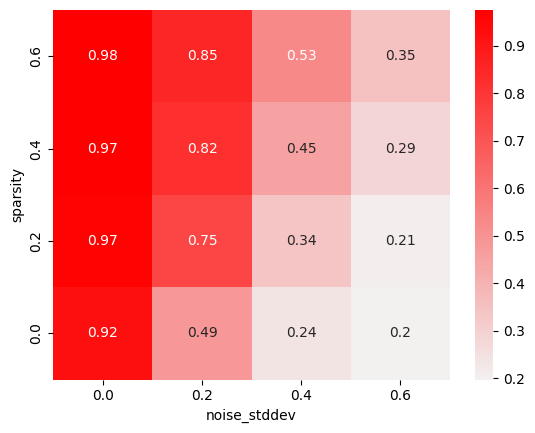

<IPython.core.display.Javascript object>

In [68]:
cm = sns.light_palette("red", as_cmap=True)
heat_map = df.pivot(index="sparsity", columns="noise_stddev", values="acc").sort_index(
    ascending=False
)
sns.heatmap(data=heat_map, cmap=cm, annot=True)

# Impact of kWTA (activation sparsity) on performance with noise added to images

sparsity = fraction of activated neurons <br>
noise = noise contained in validation set but NOT train set

- activation sparsity can help for regularisation (check if that is correct?)
- less active neurons increase performance
- performance increase is more significant in validation set with higher noise